In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import gensim
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import numpy as np
from gensim.models import Word2Vec
import dgl
import dgl.nn as gnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy
import copy

Using backend: pytorch


In [3]:
# create random graph

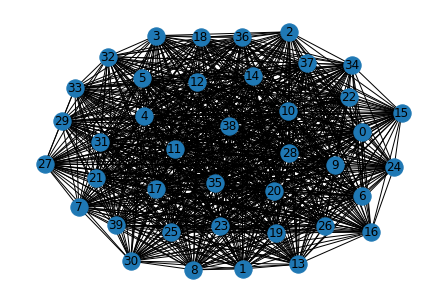

In [4]:
num_nodes = 40
def generate_graph(n, p):
    g1 = nx.gnp_random_graph(n, p)
    nx.draw(g1, pos = nx.spring_layout(g1), with_labels = True)
    # create dgl graph from networkx
    g = dgl.from_networkx(g1)
    valume1 = g.edges()[0 ].tolist()
    valume2 = g.edges()[1].tolist()
    data = np.array([valume1, valume2]).T
    data_edges = pd.DataFrame(data=data)
    weights = np.random.randint(0, 40, len(data_edges)).tolist()
    # this is necessary for the same edges to be equal
    for i in range(len(data_edges)):
        x = np.random.randint(0, 40, 1)[0]
        edge = (data_edges[0][i], data_edges[1][i])
        for j in range(len(data_edges[1])):
            if edge == (data_edges[1][j], data_edges[0][j]):
                weights[j] = weights[i] 
    data_edges['weights'] = weights
    # append weights to edges
    g.edata['weights'] = torch.tensor(weights,  dtype=torch.int32)
    return g
g = generate_graph(num_nodes, 1)

In [55]:
# generate random path

In [6]:
S0 = np.random.permutation(num_nodes).tolist()

In [7]:
# Вспомогательные функции

In [8]:
# count distance of path
def count_distance(S0):
    L = 0
    for i in range(len(S0)-1):
        L+= g.edata['weights'][S0[i+1]]
    return L
    
count_distance(S0)

# generate new random path
def generate_prob_path(path):
    len_path = len(path)
    first_city_idx = np.random.randint(0, len_path-1)
    second_city_idx = np.random.randint(0, len_path-1)
    if first_city_idx > second_city_idx:
        first_city_idx, second_city_idx = second_city_idx, first_city_idx
    new_route = copy.copy(path)
    new_route[first_city_idx : second_city_idx] = reversed(new_route[first_city_idx : second_city_idx]) 
    return new_route

def probability(difference, temperature):
    return np.e ** (-difference/temperature)

def temp_reduction(T0, k, current_k):
    return T0 * (1 - current_k/k)
    #return T0/np.log(1+current_k)
    #return T0/(current_k + 1)

In [9]:
# Основной алгоритм имитации отжига
# Гиперпараметры
k = 3000
T0 = 100

In [10]:
def simulated_annealing(path, k, T0):
    cur_route_dist = path
    process = []
    
    for cur_iter in range(k):
        # генерируем путь
        prob_path = generate_prob_path(path)
        current_path = path
        # count current and random meanings
        cur_route_dist = count_distance(current_path)
        candidate_dist = count_distance(prob_path)
        
        process.append(cur_route_dist)
        # if current path longer
        if cur_route_dist > candidate_dist:
            # переходим в рандом
            path = prob_path
            cur_route_fitness = current_path
        else:
            # count temperature
            cur_iter_temp = temp_reduction(T0, k, cur_iter)
            func_val_diff = candidate_dist - cur_route_dist
            # вероятность перехода в новое состояние, которое хуже по дистанции
            random_val = np.random.uniform(0, 1)
            cur_iter_transition_prob = probability(func_val_diff, cur_iter_temp)
            # переходим в зависимости от случайной величины
            if random_val <= cur_iter_transition_prob:
                path = prob_path
                cur_route_fitness = current_path
                
   
    fig = plt.figure(figsize=(5,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.plot(process)
    plt.title('Dependence of distance from interation')
    plt.xlabel('Number of iteretion')
    plt.ylabel('Distance');
    
    return path

path:[15, 35, 20, 39, 10, 12, 29, 18, 36, 17, 14, 24, 7, 19, 27, 1, 38, 13, 0, 30, 6, 9, 22, 5, 34, 32, 33, 2, 25, 3, 21, 11, 4, 28, 23, 26, 16, 37, 31, 8]
 стоимость пути: 720


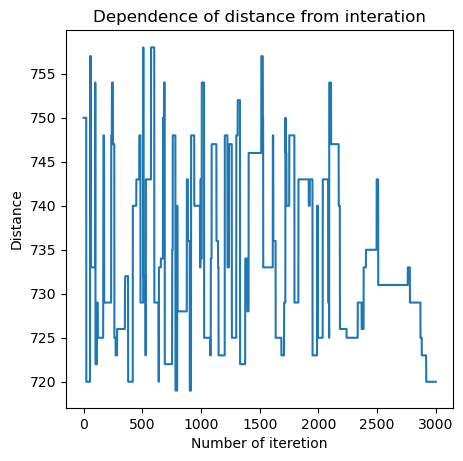

In [14]:
S = simulated_annealing(S0, k, T0)
print(f'path:{S}')
print(f' стоимость пути: {count_distance(S)}')